#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import pyro
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import StudentTCopula
from bvcopula import GPInferenceModel, KISS_GPInferenceModel

pyro.enable_validation(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
#here we specify a 'true' latent function lambda
scale = lambda x: np.sin(2*np.pi*1*x)*1.+0.0 #*np.sin(2*np.pi*3*x+.6)

(1000, 2)


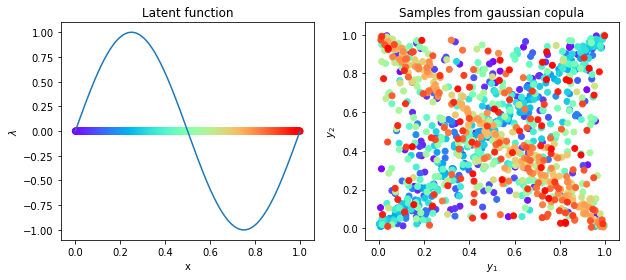

In [5]:
# here we generate some synthetic samples
from starvine.bvcopula.copula.gauss_copula import GaussCopula
import matplotlib.cm as cm

NSamp = 1e3

X = np.linspace(0,1,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

# Y = np.zeros((NSamp,2))
# copula = GaussCopula()
# for i,x in enumerate(X):
#     if scale(x) == 0:
#         Y[i] = np.random.uniform(low=0,high=1,size=2)
#     else:
#         Y[i] = np.array(copula.sample(1,scale(x))).T # size=1
scales = [scale(x) for x in X]
model = StudentTCopula(torch.tensor(scales).float())
Y = model.sample().numpy().squeeze()
print(Y.shape)
colors = cm.rainbow(np.linspace(0, 1, NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from gaussian copula')

fig.show()

In [4]:
Y[Y == float("inf")]

array([], dtype=float32)

In [5]:
Y[Y == float('nan')]

array([], dtype=float32)

In [6]:
(np.min(Y),np.max(Y))

(0.037023295, 0.99109596)

In [7]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float()#.cuda(device=0)
train_y = torch.tensor(Y).float()#.cuda(device=0)

In [8]:
class KISS_GPInferenceModel2(gpytorch.models.PyroVariationalGP):
    def __init__(self, likelihood, prior_rbf_length=0.1, grid_size=128, grid_bounds=[(0, 1)], name_prefix="mixture_gp"):
        # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(grid_size)
        variational_strategy = gpytorch.variational.GridInterpolationVariationalStrategy(
            self, grid_size, grid_bounds, variational_distribution
        )
        
        # Standard initializtation
        super(KISS_GPInferenceModel2, self).__init__(variational_strategy, likelihood, num_data=grid_size) #?
        self.likelihood = likelihood
        
        # Mean, covar
        self.mean_module = gpytorch.means.ConstantMean()
        
        #we specify prior here
        lengthscale_prior = gpytorch.priors.NormalPrior(prior_rbf_length, 1.0) #variance does not matter much
        
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
        )
        
        # Initialize lengthscale and outputscale to mean of priors
        self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
        #self.covar_module.outputscale = outputscale_prior.mean

    def forward(self, x):
        mean = self.mean_module(x)  # Returns an n_data vec
        covar = self.covar_module(x)
        if mean[mean == float("nan")].shape[-1] > 0:
            print("Nans!")
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [9]:
# define the model (optionally on GPU)
grid_size = 128
#model = GPInferenceModel(train_x, train_y, GaussianCopula_Likelihood())#.cuda(device=0)
model = KISS_GPInferenceModel2(ClaytonCopula_Likelihood(), prior_rbf_length=0.2, grid_size=grid_size)#.cuda(device=0)
# model.covar_module = gpytorch.kernels.ScaleKernel(
#             gpytorch.kernels.MaternKernel(nu=1.5, lengthscale_prior=0.5)
#             #gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
#         )

In [10]:
# train the model
from pyro import optim

base_lr = 1e-3
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

# set learning rates for different hyperparameters
def per_param_callable(module_name, param_name):
    if param_name == 'covar_module.base_kernel.raw_lengthscale':
        return {"lr": .05} #.1 for 256 particles
    elif param_name == 'variational_strategy.variational_distribution.variational_mean':
        return {"lr": .1}
    else:
        #print(param_name)
        return {"lr": base_lr}

# Use the adam optimizer
optimizer = optim.Adam(per_param_callable)

pyro.clear_param_store() # clean run

losses, rbf, means = [], [], []

def train(num_iter=3000):
    elbo = pyro.infer.Trace_ELBO(num_particles=128, vectorize_particles=True, max_plate_nesting=1)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    p = 0.
    for i in range(num_iter):
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss)
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().numpy().copy())
        if not (i + 1) % iter_print:
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {:.3}, dLoss: {:.3}, mean f: {:.3}, dmean: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(), mean_p/np.abs(loss), np.mean(means[-1]), np.mean(np.abs(1-means[-100]/means[-1]))
            ))
            
            #print(np.std(losses[-100:]))
            if (0 < mean_p/np.abs(loss) < 0.01):# & (np.mean(np.abs(1-means[-100]/means[-1])) < 0.05): 
                print("Converged!")
                break
            p = 0.
        
%time train()

Basic lr for most of parameters: 0.001
Iter 100/3000 - Loss: -40.8   lengthscale: 0.167, dLoss: 0.0, mean f: 0.0518, dmean: 3.04
Iter 200/3000 - Loss: -45.5   lengthscale: 0.188, dLoss: 0.272, mean f: 0.155, dmean: 0.609
Iter 300/3000 - Loss: -53.2   lengthscale: 0.191, dLoss: 0.0656, mean f: 0.304, dmean: 0.437
Iter 400/3000 - Loss: -64.6   lengthscale: 0.189, dLoss: 0.0662, mean f: 0.491, dmean: 0.32
Iter 500/3000 - Loss: -75.1   lengthscale: 0.188, dLoss: 0.0728, mean f: 0.698, dmean: 0.354
Iter 600/3000 - Loss: -83.3   lengthscale: 0.186, dLoss: 0.0619, mean f: 0.898, dmean: 0.189
Iter 700/3000 - Loss: -90.2   lengthscale: 0.186, dLoss: 0.0412, mean f: 1.06, dmean: 0.158
Iter 800/3000 - Loss: -93.8   lengthscale: 0.185, dLoss: 0.0251, mean f: 1.19, dmean: 0.123
Iter 900/3000 - Loss: -95.5   lengthscale: 0.186, dLoss: 0.0118, mean f: 1.28, dmean: 0.0891
Iter 1000/3000 - Loss: -95.9   lengthscale: 0.186, dLoss: 0.0118, mean f: 1.34, dmean: 0.0607
Iter 1100/3000 - Loss: -97.0   length

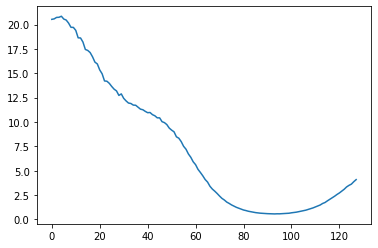

In [16]:
plt.plot(np.exp(means[-1]))

In [23]:
help(torch.distributions.studentT)

Help on module torch.distributions.studentT in torch.distributions:

NAME
    torch.distributions.studentT

CLASSES
    torch.distributions.distribution.Distribution(builtins.object)
        StudentT
    
    class StudentT(torch.distributions.distribution.Distribution)
     |  Creates a Student's t-distribution parameterized by degree of
     |  freedom :attr:`df`, mean :attr:`loc` and scale :attr:`scale`.
     |  
     |  Example::
     |  
     |      >>> m = StudentT(torch.tensor([2.0]))
     |      >>> m.sample()  # Student's t-distributed with degrees of freedom=2
     |      tensor([ 0.1046])
     |  
     |  Args:
     |      df (float or Tensor): degrees of freedom
     |      loc (float or Tensor): mean of the distribution
     |      scale (float or Tensor): scale of the distribution
     |  
     |  Method resolution order:
     |      StudentT
     |      torch.distributions.distribution.Distribution
     |      builtins.object
     |  
     |  Methods defined here:
     |

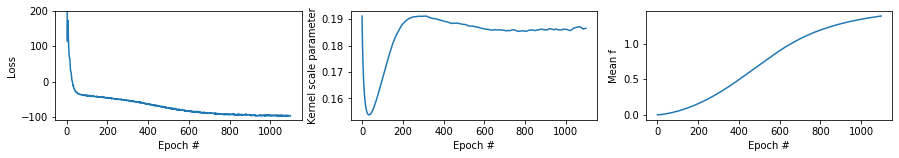

In [17]:
# prot loss function and kernel length
fig, (loss, kern, mean) = plt.subplots(1,3,figsize=(15,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
loss.set_ylim(np.min(losses)*1.1,200)
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

In [18]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float()#.cuda(device=0)

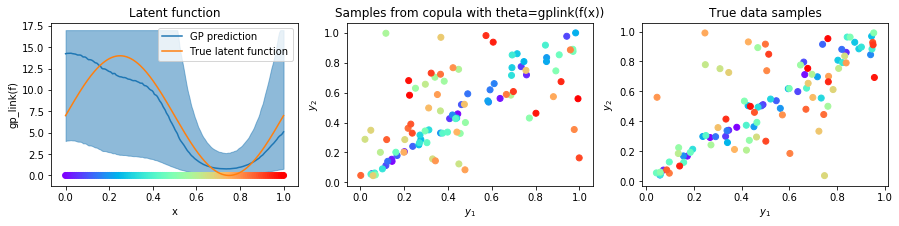

In [14]:
# visualize the result
fig, (func, sim, true) = plt.subplots(1,3,figsize=(15, 3))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function
 
samples = output.rsample(torch.Size([2048]))
F_mean = gplink(samples).mean(0).detach().cpu().numpy()
#F_mean = gplink(output.mean).detach().cpu().numpy()
line, = func.plot(testX, F_mean, label = 'GP prediction')
lower, upper = output.confidence_region()
func.fill_between(testX, gplink(lower).detach().cpu().numpy(),
                gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

func.plot(testX,scale(testX), label = 'True latent function')
func.scatter(X,np.zeros_like(X),color=colors)
func.set_xlabel('x')
func.set_ylabel('gp_link(f)')
func.set_title('Latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
skip = 1
true.scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
sim.scatter(*Y_sim[:,:,::skip].T, label = 'Sample from the model', color=colors[::skip])
for ax in [sim,true]:
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
sim.set_title('Samples from copula with theta=gplink(f(x))')
true.set_title('True data samples')
# samp.legend()

fig.show()

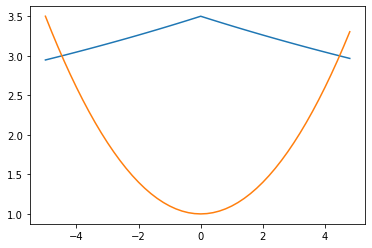

In [15]:
x = np.arange(-5,5,0.2)
plt.plot(x,(1.+2.5*np.exp(-np.abs(x)*0.05)))
plt.plot(x,1+0.1*x**2)